# Import Library

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
from plotly import express as px, graph_objects as go

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

In [2]:
rcParams['figure.figsize'] = (12, 9) # Konfigurasi jendela figure

# Fetching dataset

In [3]:
train = pd.read_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                    usecols = ['date', 'store_nbr', 'family', 'sales'])
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train

sales
date       store_nbr family                              
2013-01-01 1         AUTOMOTIVE                     0.000
                     BABY CARE                      0.000
                     BEAUTY                         0.000
                     BEVERAGES                      0.000
                     BOOKS                          0.000
...                                                   ...
2017-08-15 9         POULTRY                      438.133
                     PREPARED FOODS               154.553
                     PRODUCE                     2419.729
                     SCHOOL AND OFFICE SUPPLIES   121.000
                     SEAFOOD                       16.000

[3000888 rows x 1 columns]

In [4]:
test = pd.read_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

# Calendar Engineering

In [5]:
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)

We make date in calendar from beginning of train until last date of test.

We also concatenate calendar with oil price.

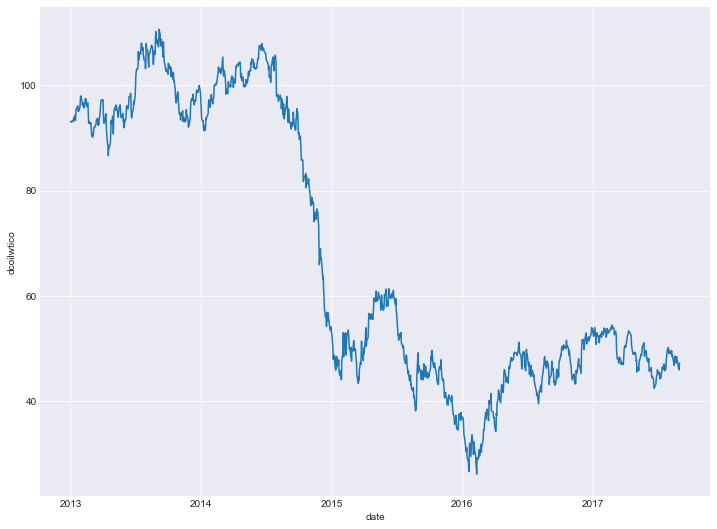

In [6]:
# Plotting oil price
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

You can see that oil price is only high at 2013 to 2014, however in 2015 it's starting to go down.

So, because we only predict 16 data points we will only need the training data from at least 2015

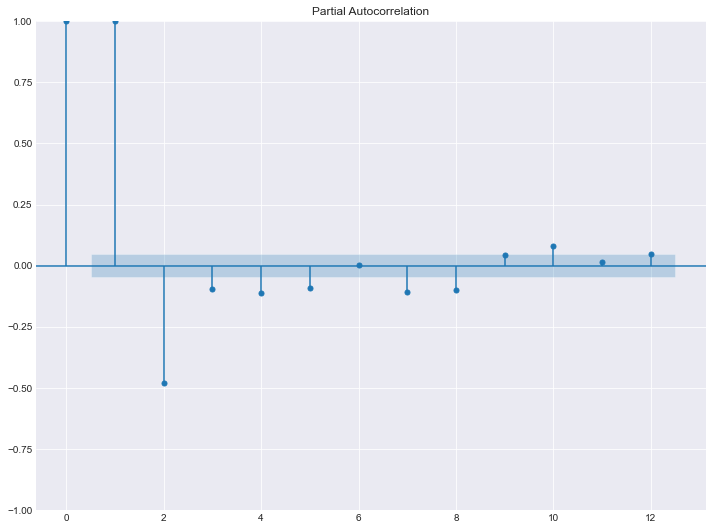

In [7]:
_ = plot_pacf(calendar.avg_oil, lags = 12) # Lagplot oil price (Feature Engineering)

You can see that max value for making a lags is up to 5, but you can take whatever you want.

I'm taking 3 lags of oil

# Adding lags

In [8]:
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar

avg_oil  oil_lags1  oil_lags2  oil_lags3
2013-01-13  93.284286  93.284286  93.284286  93.218571
2013-01-14  93.470000  93.284286  93.284286  93.284286
2013-01-15  93.490000  93.470000  93.284286  93.284286
2013-01-16  93.644286  93.490000  93.470000  93.284286
2013-01-17  93.970000  93.644286  93.490000  93.470000
...               ...        ...        ...        ...
2017-08-27  47.720000  47.720000  47.720000  47.598571
2017-08-28  47.624286  47.720000  47.720000  47.720000
2017-08-29  47.320000  47.624286  47.720000  47.720000
2017-08-30  47.115714  47.320000  47.624286  47.720000
2017-08-31  47.060000  47.115714  47.320000  47.624286

[1692 rows x 4 columns]

# Correlation plot

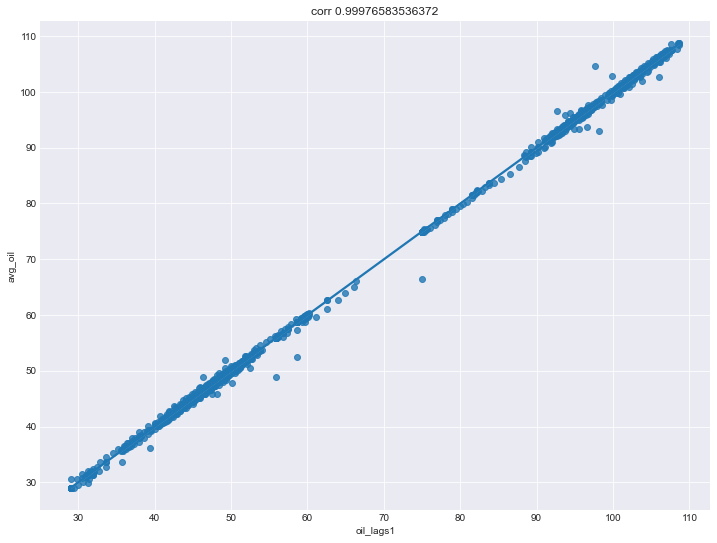

In [9]:
lag = 'oil_lags1'
plt.figure()
sns.regplot(x = calendar[lag], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag])}')
plt.show()

# Fetching holiday dataset

In [10]:
hol = pd.read_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] # I'm only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol

type    locale locale_name  \
date                                           
2012-08-10     Holiday  National     Ecuador   
2012-10-09     Holiday  National     Ecuador   
2012-10-12    Transfer  National     Ecuador   
2012-11-02     Holiday  National     Ecuador   
2012-11-03     Holiday  National     Ecuador   
...                ...       ...         ...   
2017-12-22  Additional  National     Ecuador   
2017-12-23  Additional  National     Ecuador   
2017-12-24  Additional  National     Ecuador   
2017-12-25     Holiday  National     Ecuador   
2017-12-26  Additional  National     Ecuador   

                                    description  transferred  
date                                                          
2012-08-10        Primer Grito de Independencia        False  
2012-10-09           Independencia de Guayaquil         True  
2012-10-12  Traslado Independencia de Guayaquil        False  
2012-11-02                      Dia de Difuntos        False  
2012-11-03              Independencia de Cuenca        False  
...                                         ...          ...  
2017-12-22                            Navidad-3        False  
2017-12-23                            Navidad-2        False  
2017-12-24                            Navidad-1        False  
2017-12-25                              Navidad        False  
2017-12-26                            Navidad+1        False  

[168 rows x 5 columns]

# Feature Engineering for holiday

In [11]:
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not Weekday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a work day
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a work day
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar

avg_oil  oil_lags1  oil_lags2  oil_lags3  wd  dofw_1  dofw_2  \
2013-01-13  93.284286  93.284286  93.284286  93.218571   0       0       0   
2013-01-14  93.470000  93.284286  93.284286  93.284286   1       0       0   
2013-01-15  93.490000  93.470000  93.284286  93.284286   1       1       0   
2013-01-16  93.644286  93.490000  93.470000  93.284286   1       0       1   
2013-01-17  93.970000  93.644286  93.490000  93.470000   1       0       0   
...               ...        ...        ...        ...  ..     ...     ...   
2017-08-27  47.720000  47.720000  47.720000  47.598571   0       0       0   
2017-08-28  47.624286  47.720000  47.720000  47.720000   1       0       0   
2017-08-29  47.320000  47.624286  47.720000  47.720000   1       1       0   
2017-08-30  47.115714  47.320000  47.624286  47.720000   1       0       1   
2017-08-31  47.060000  47.115714  47.320000  47.624286   1       0       0   

            dofw_3  dofw_4  dofw_5  dofw_6  type_Additional  type_Bridge  \
2013-01-13       0       0       0       1                0            0   
2013-01-14       0       0       0       0                0            0   
2013-01-15       0       0       0       0                0            0   
2013-01-16       0       0       0       0                0            0   
2013-01-17       1       0       0       0                0            0   
...            ...     ...     ...     ...              ...          ...   
2017-08-27       0       0       0       1                0            0   
2017-08-28       0       0       0       0                0            0   
2017-08-29       0       0       0       0                0            0   
2017-08-30       0       0       0       0                0            0   
2017-08-31       1       0       0       0                0            0   

            type_Event  type_Holiday  type_Transfer  type_Work Day  
2013-01-13           0             0              0              0  
2013-01-14           0             0              0              0  
2013-01-15           0             0              0              0  
2013-01-16           0             0              0              0  
2013-01-17           0             0              0              0  
...                ...           ...            ...            ...  
2017-08-27           0             0              0              0  
2017-08-28           0             0              0              0  
2017-08-29           0             0              0              0  
2017-08-30           0             0              0              0  
2017-08-31           0             0              0              0  

[1692 rows x 17 columns]

In [ ]:
# calendar['wd_lag1'] = calendar.wd.shift(1)
# calendar['wd_fore1'] = calendar.wd.shift(-1).fillna(0)
# calendar.dropna(inplace = True)
# calendar

# Dependent Variable Viz

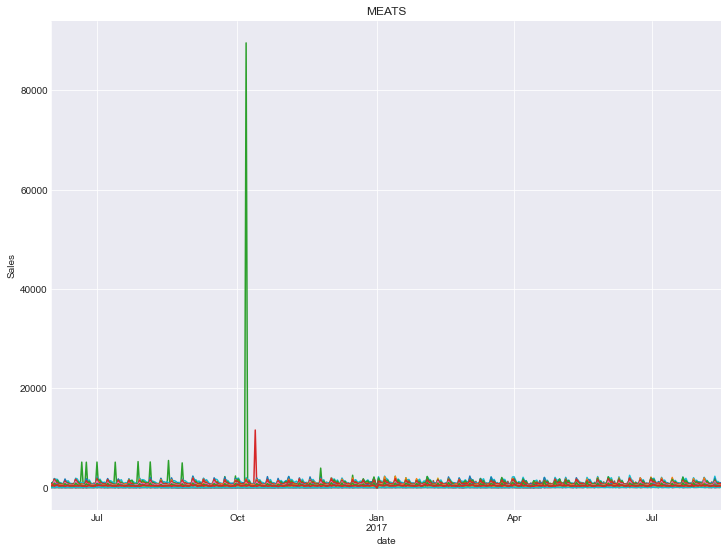

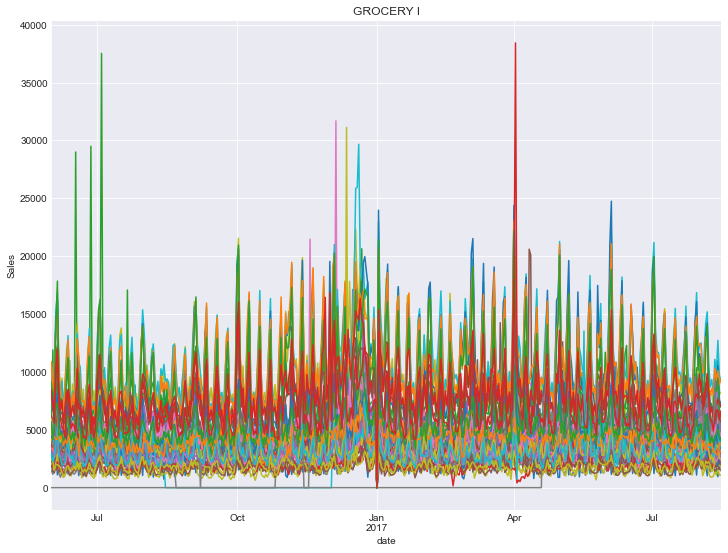

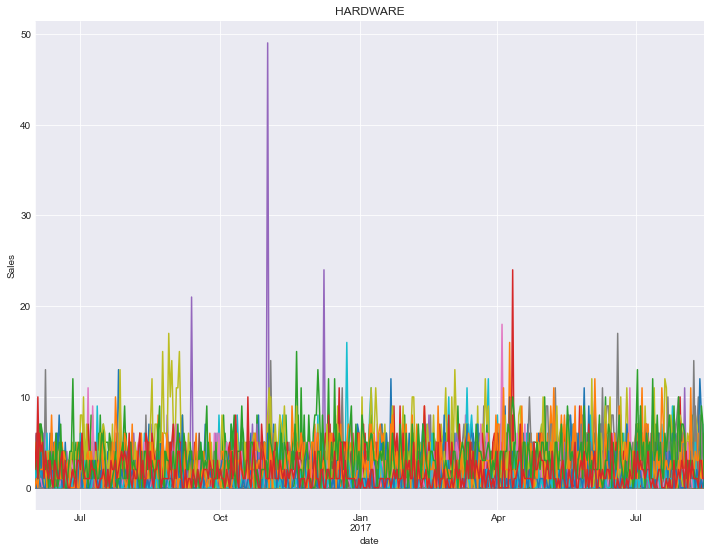

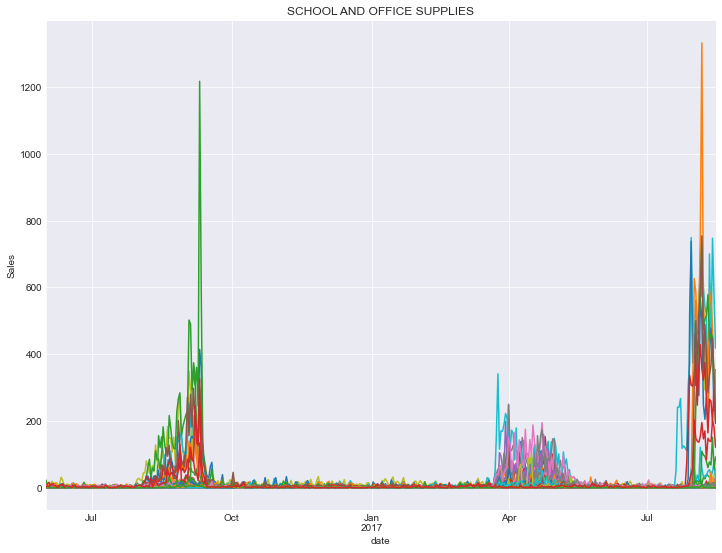

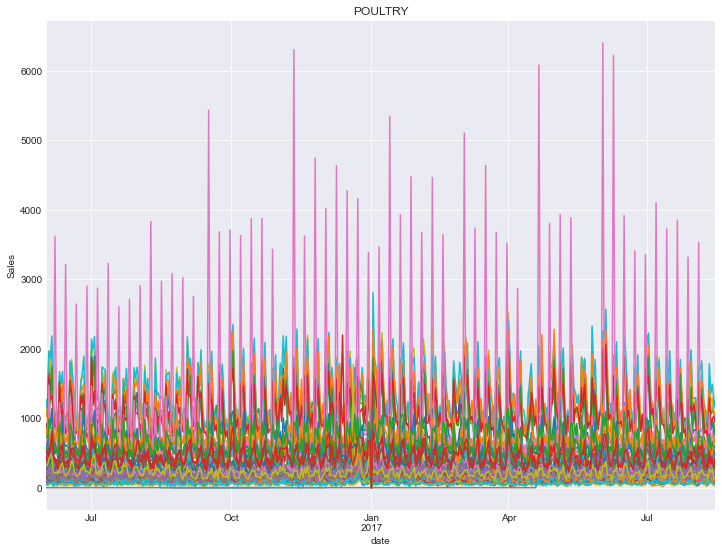

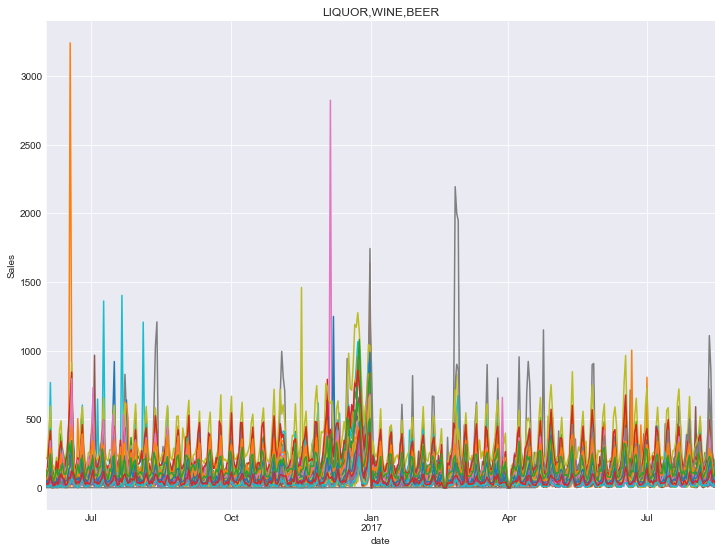

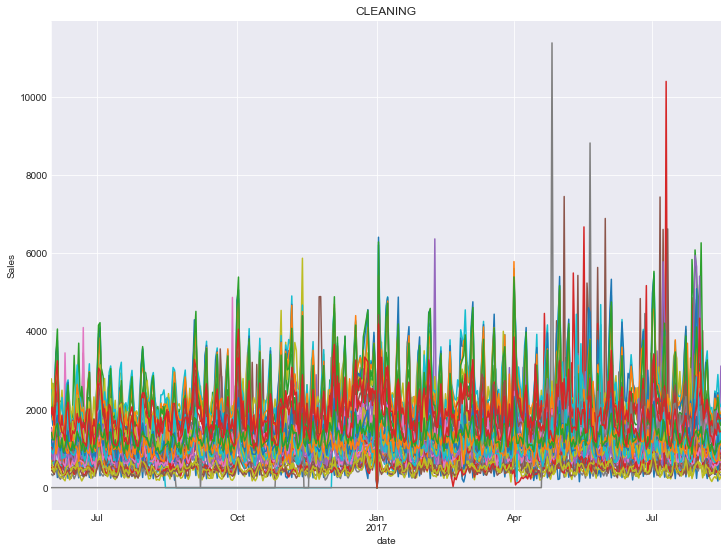

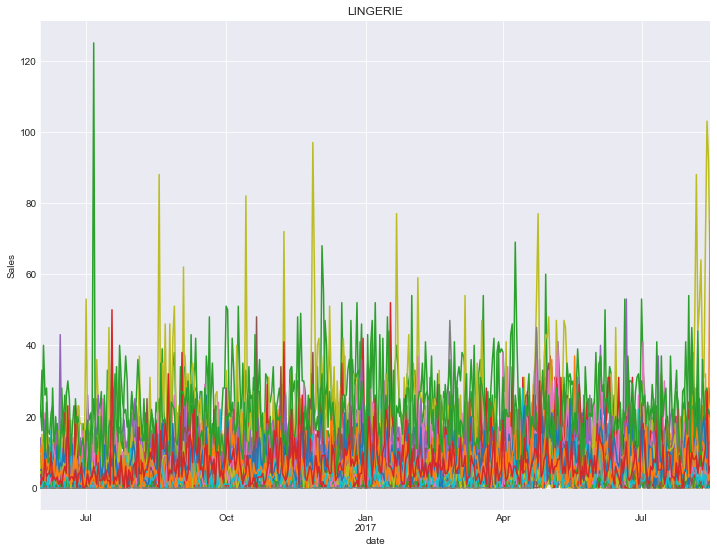

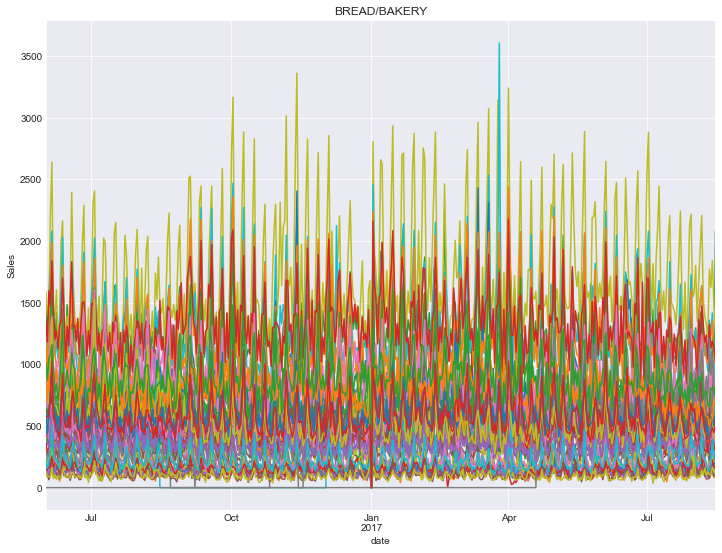

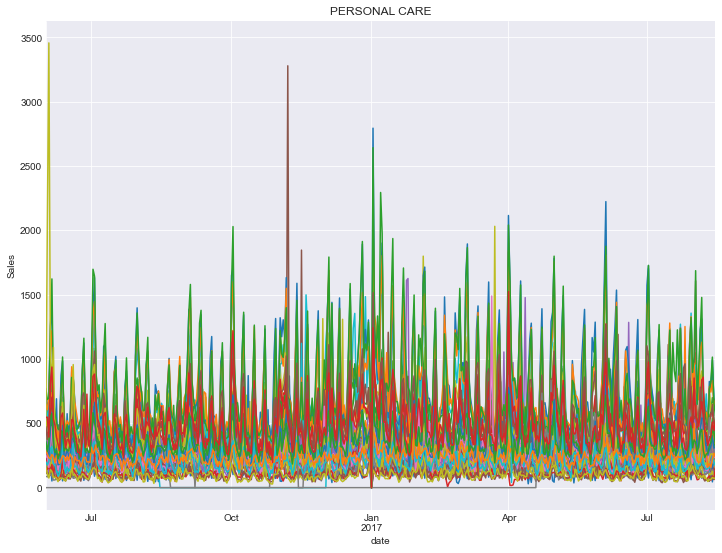

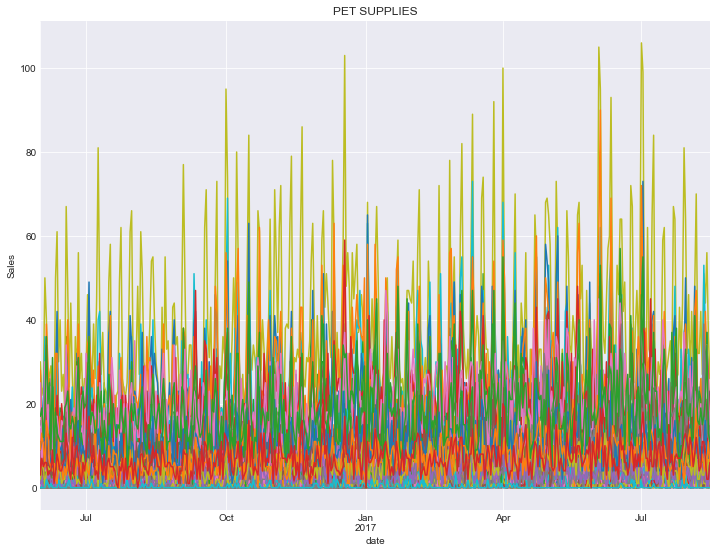

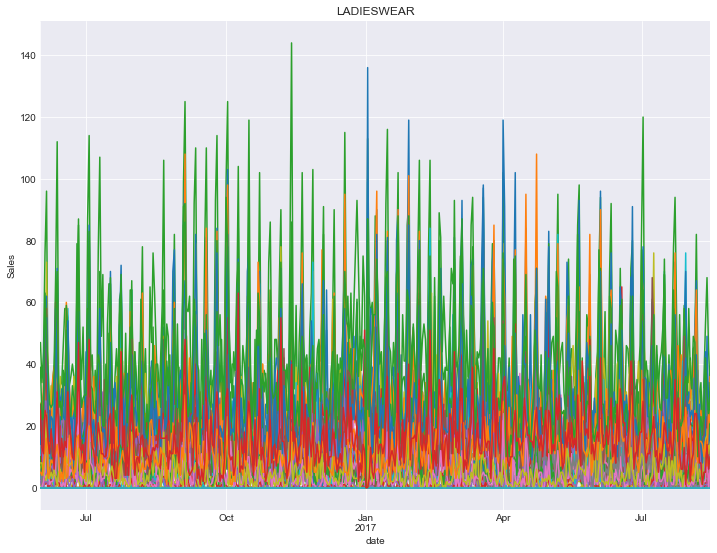

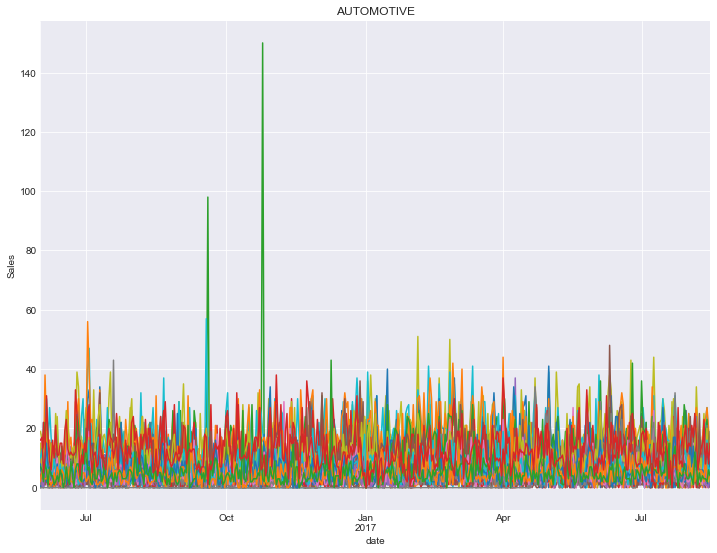

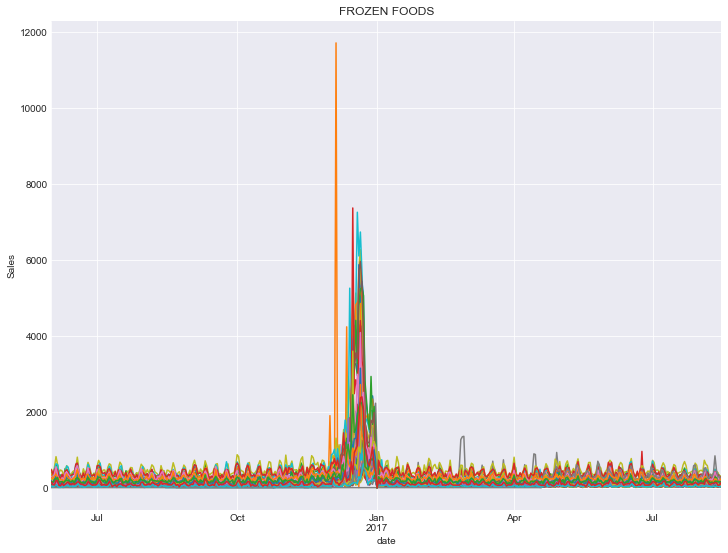

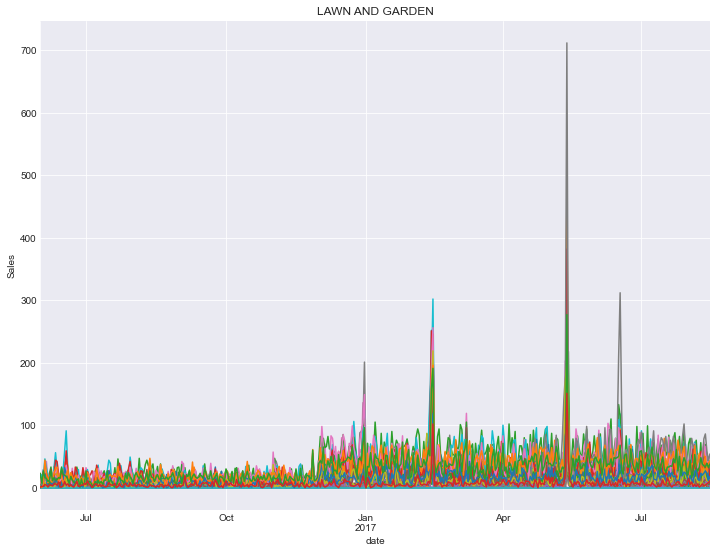

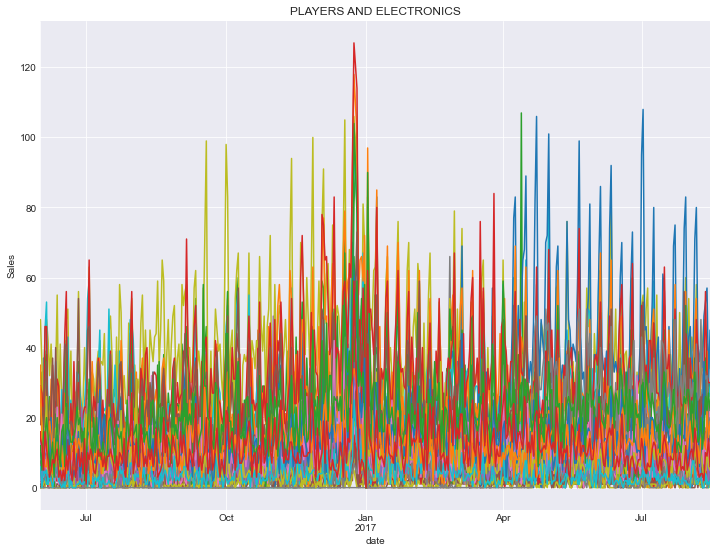

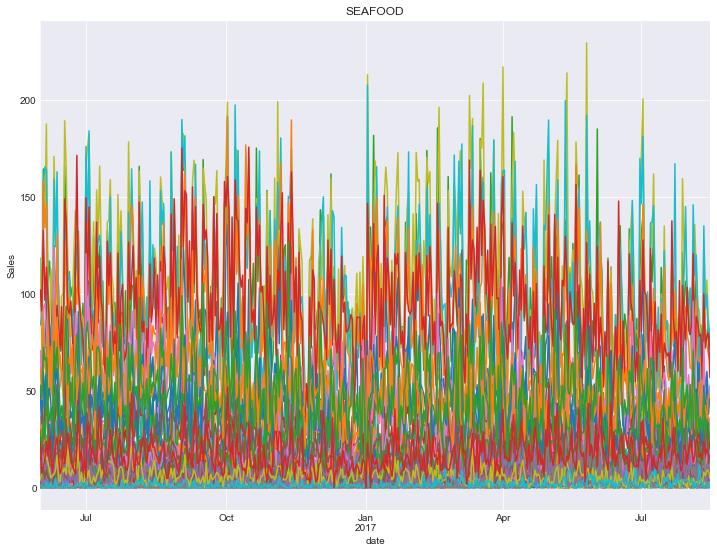

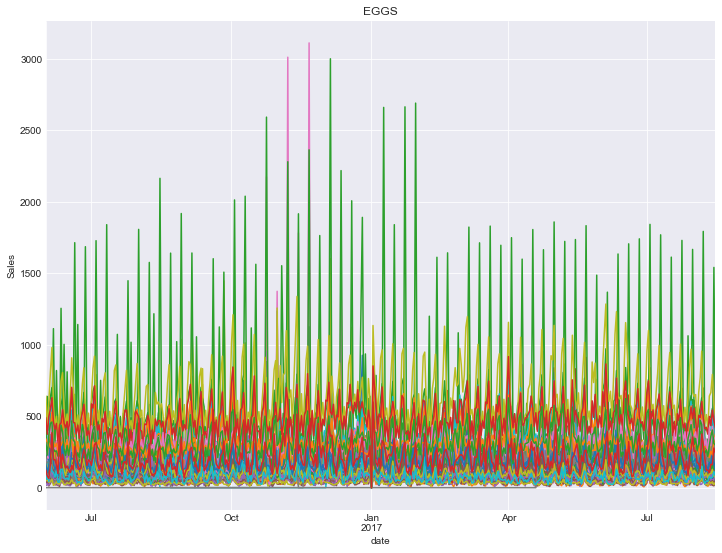

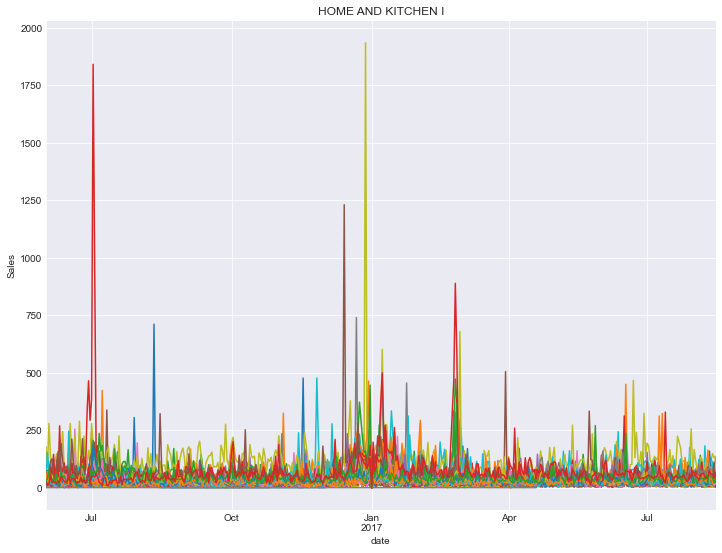

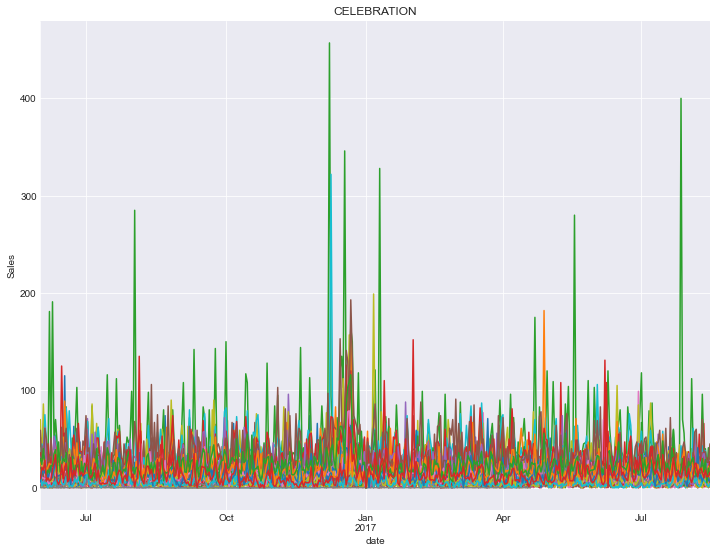

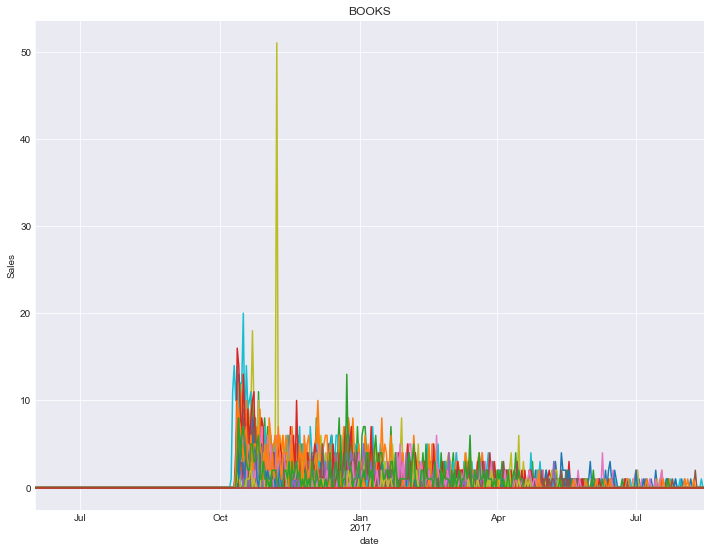

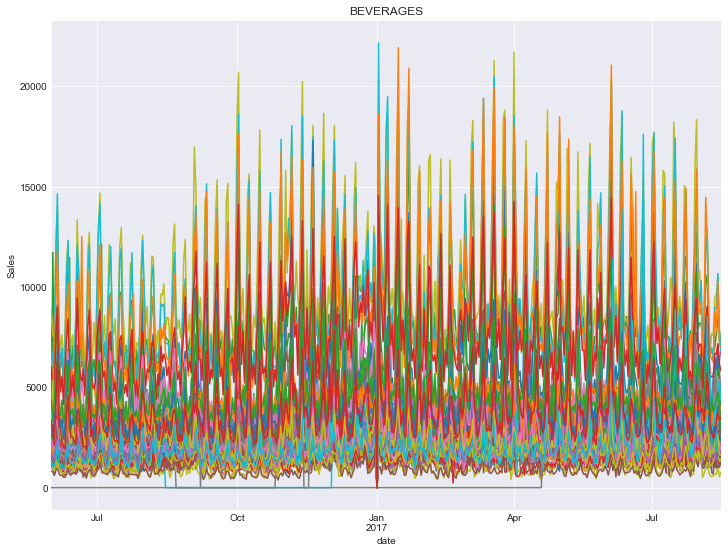

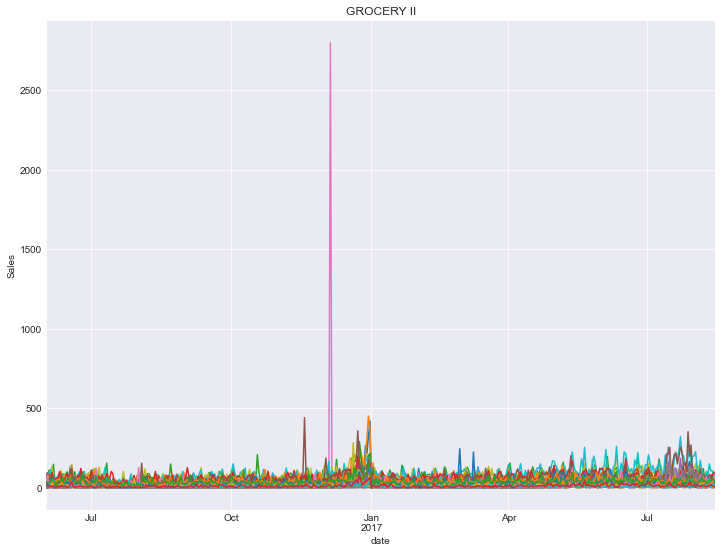

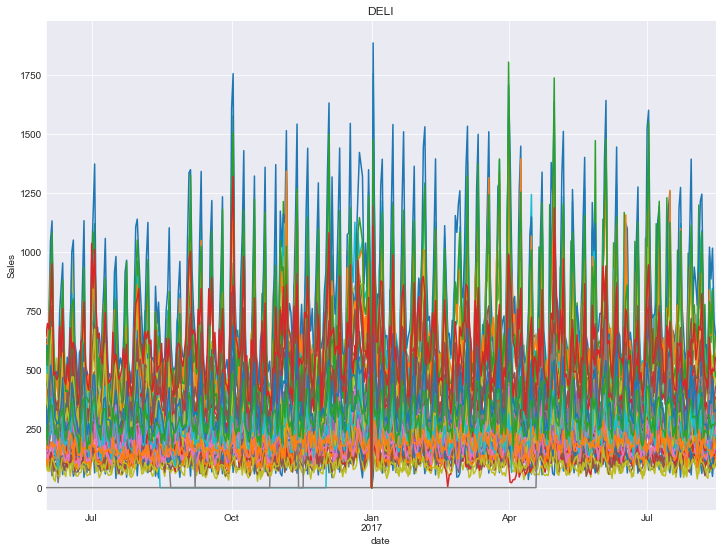

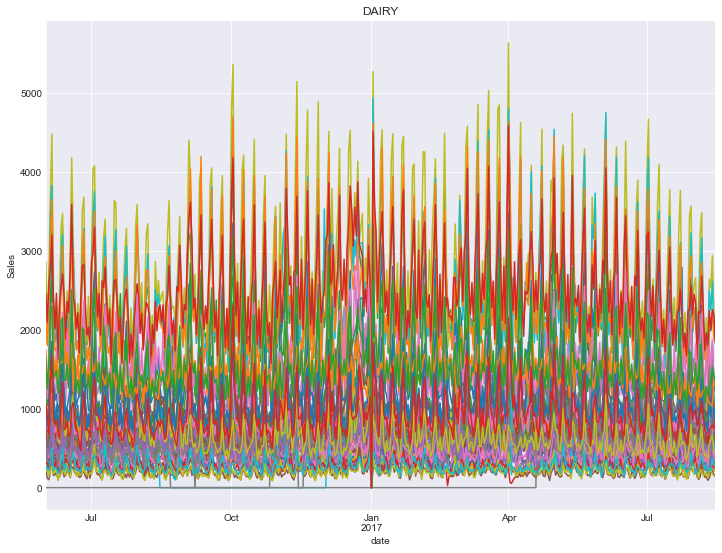

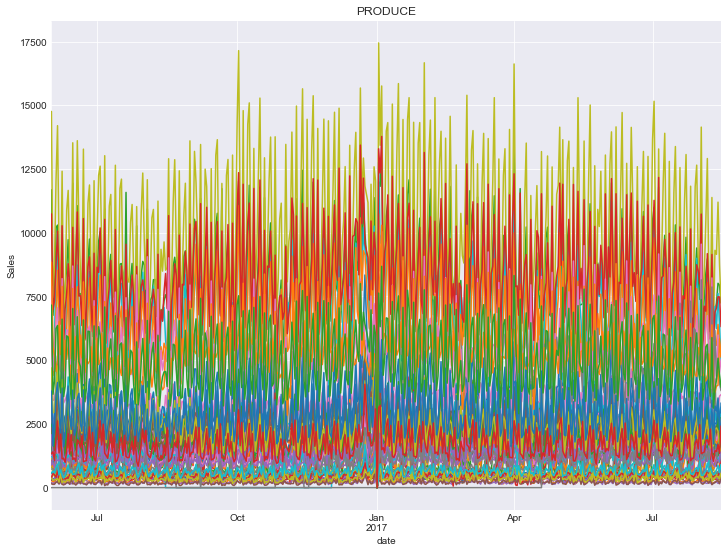

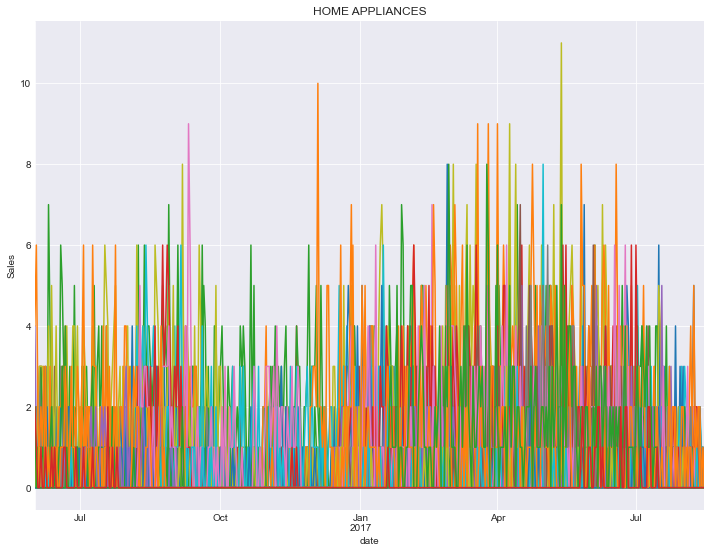

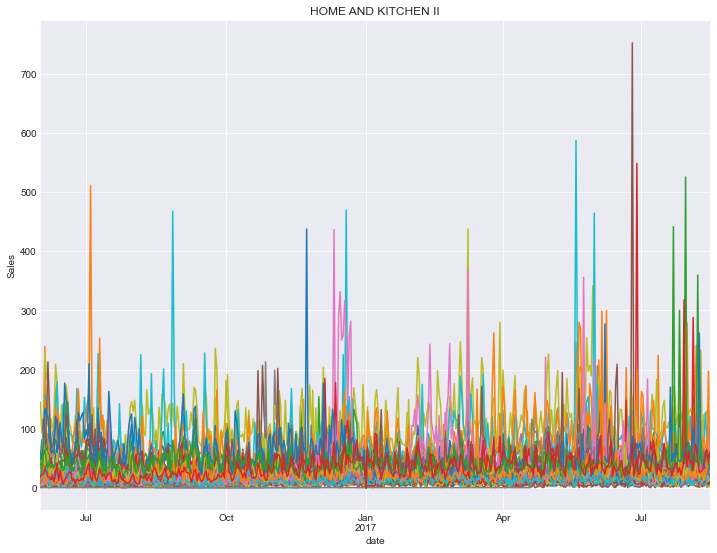

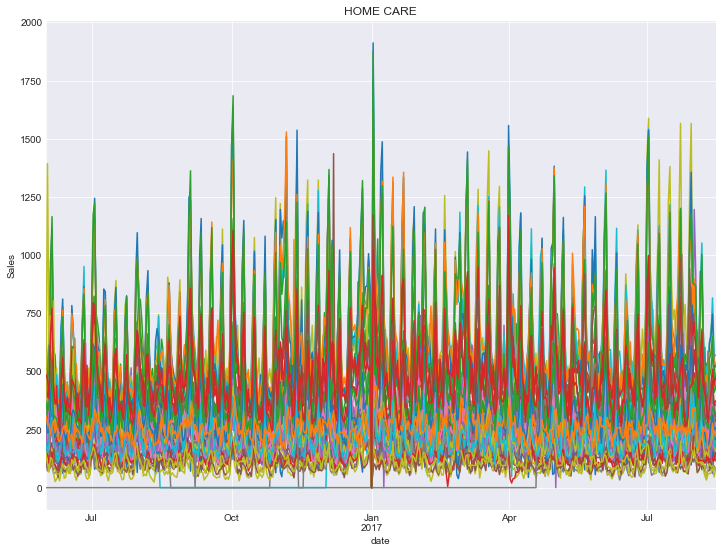

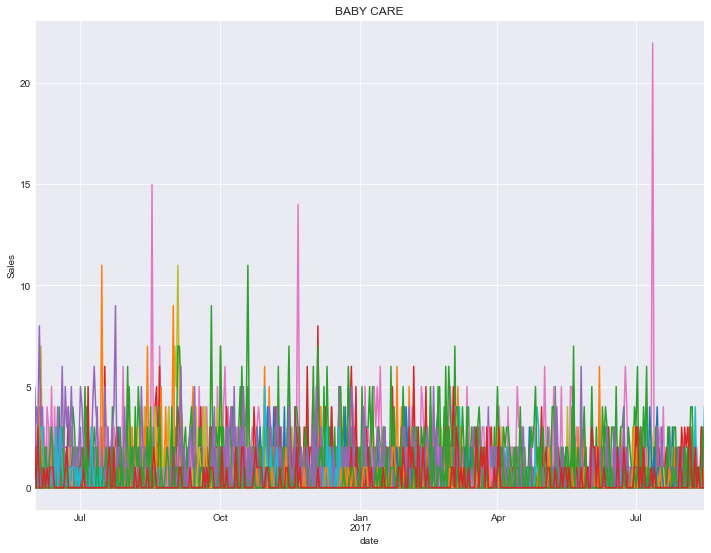

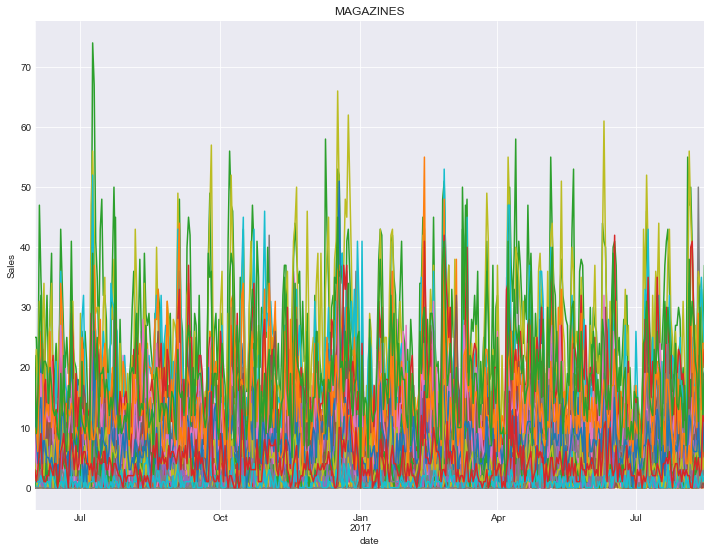

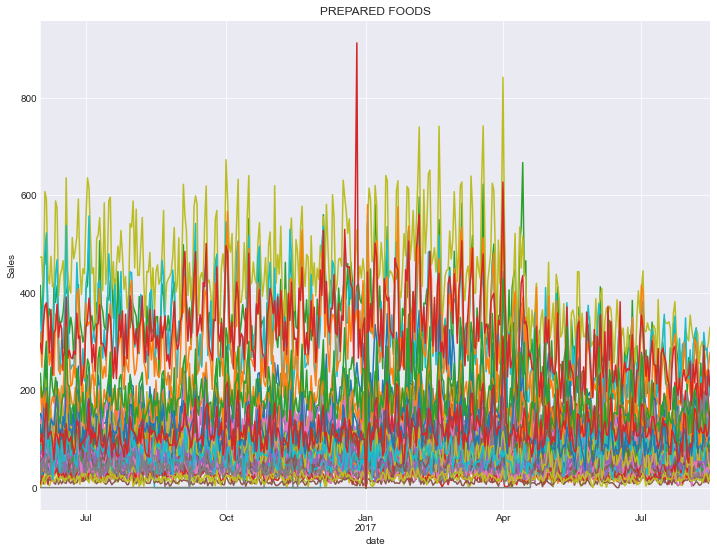

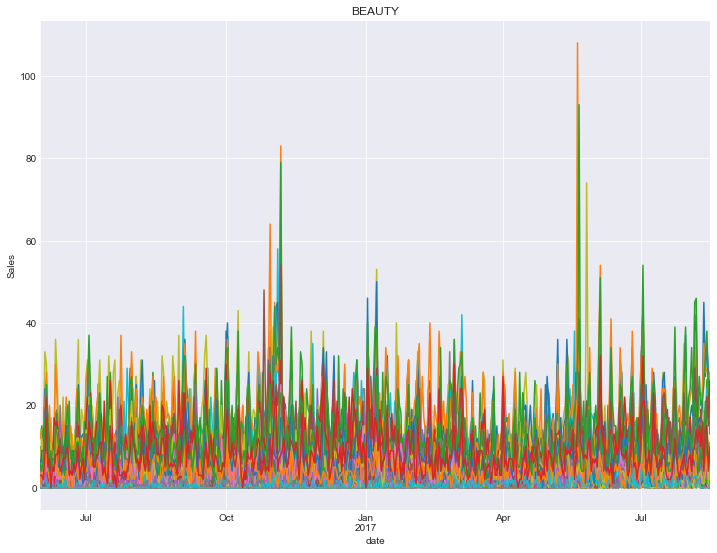

In [12]:
y = train.unstack(['store_nbr', 'family']).loc['2016-06':'2017']
family = {c[2] for c in train.index}
for f in family :
    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
    ax.set_title(f)
    ax.set_ylabel("Sales")

Graphs above are the visualization of each product

In [13]:
sdate = '2017-04-30' # Start and end of training date
edate = '2017-08-15'

In [14]:
school_season = [] # Feature for school fluctuations
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar

avg_oil  oil_lags1  oil_lags2  oil_lags3  wd  dofw_1  dofw_2  \
2013-01-13  93.284286  93.284286  93.284286  93.218571   0       0       0   
2013-01-14  93.470000  93.284286  93.284286  93.284286   1       0       0   
2013-01-15  93.490000  93.470000  93.284286  93.284286   1       1       0   
2013-01-16  93.644286  93.490000  93.470000  93.284286   1       0       1   
2013-01-17  93.970000  93.644286  93.490000  93.470000   1       0       0   
...               ...        ...        ...        ...  ..     ...     ...   
2017-08-27  47.720000  47.720000  47.720000  47.598571   0       0       0   
2017-08-28  47.624286  47.720000  47.720000  47.720000   1       0       0   
2017-08-29  47.320000  47.624286  47.720000  47.720000   1       1       0   
2017-08-30  47.115714  47.320000  47.624286  47.720000   1       0       1   
2017-08-31  47.060000  47.115714  47.320000  47.624286   1       0       0   

            dofw_3  dofw_4  dofw_5  dofw_6  type_Additional  type_Bridge  \
2013-01-13       0       0       0       1                0            0   
2013-01-14       0       0       0       0                0            0   
2013-01-15       0       0       0       0                0            0   
2013-01-16       0       0       0       0                0            0   
2013-01-17       1       0       0       0                0            0   
...            ...     ...     ...     ...              ...          ...   
2017-08-27       0       0       0       1                0            0   
2017-08-28       0       0       0       0                0            0   
2017-08-29       0       0       0       0                0            0   
2017-08-30       0       0       0       0                0            0   
2017-08-31       1       0       0       0                0            0   

            type_Event  type_Holiday  type_Transfer  type_Work Day  \
2013-01-13           0             0              0              0   
2013-01-14           0             0              0              0   
2013-01-15           0             0              0              0   
2013-01-16           0             0              0              0   
2013-01-17           0             0              0              0   
...                ...           ...            ...            ...   
2017-08-27           0             0              0              0   
2017-08-28           0             0              0              0   
2017-08-29           0             0              0              0   
2017-08-30           0             0              0              0   
2017-08-31           0             0              0              0   

            school_season  
2013-01-13              0  
2013-01-14              0  
2013-01-15              0  
2013-01-16              0  
2013-01-17              0  
...                   ...  
2017-08-27              1  
2017-08-28              1  
2017-08-29              1  
2017-08-30              1  
2017-08-31              1  

[1692 rows x 18 columns]

# DeterministicProcess

In [15]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 4)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
date                                                                         
2017-04-30    1.0          -0.781831           0.623490          -0.974928   
2017-05-01    2.0           0.000000           1.000000           0.000000   
2017-05-02    3.0           0.781831           0.623490           0.974928   
2017-05-03    4.0           0.974928          -0.222521          -0.433884   
2017-05-04    5.0           0.433884          -0.900969          -0.781831   
...           ...                ...                ...                ...   
2017-08-11  104.0          -0.433884          -0.900969           0.781831   
2017-08-12  105.0          -0.974928          -0.222521           0.433884   
2017-08-13  106.0          -0.781831           0.623490          -0.974928   
2017-08-14  107.0           0.000000           1.000000           0.000000   
2017-08-15  108.0           0.781831           0.623490           0.974928   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
date                                                                  
2017-04-30          -0.222521          -0.433884          -0.900969   
2017-05-01           1.000000           0.000000           1.000000   
2017-05-02          -0.222521           0.433884          -0.900969   
2017-05-03          -0.900969          -0.781831           0.623490   
2017-05-04           0.623490           0.974928          -0.222521   
...                       ...                ...                ...   
2017-08-11           0.623490          -0.974928          -0.222521   
2017-08-12          -0.900969           0.781831           0.623490   
2017-08-13          -0.222521          -0.433884          -0.900969   
2017-08-14           1.000000           0.000000           1.000000   
2017-08-15          -0.222521           0.433884          -0.900969   

              avg_oil  oil_lags1  oil_lags2  ...  dofw_4  dofw_5  dofw_6  \
date                                         ...                           
2017-04-30  49.358571  49.358571  49.358571  ...       0       0       1   
2017-05-01  49.154286  49.358571  49.358571  ...       0       0       0   
2017-05-02  48.870000  49.154286  49.358571  ...       0       0       0   
2017-05-03  48.711429  48.870000  49.154286  ...       0       0       0   
2017-05-04  48.187143  48.711429  48.870000  ...       0       0       0   
...               ...        ...        ...  ...     ...     ...     ...   
2017-08-11  49.140000  49.252857  49.345714  ...       1       0       0   
2017-08-12  49.140000  49.140000  49.252857  ...       0       1       0   
2017-08-13  49.140000  49.140000  49.140000  ...       0       0       1   
2017-08-14  48.934286  49.140000  49.140000  ...       0       0       0   
2017-08-15  48.648571  48.934286  49.140000  ...       0       0       0   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
date                                                                 
2017-04-30                0            0           0             0   
2017-05-01                0            0           0             1   
2017-05-02                0            0           0             0   
2017-05-03                0            0           0             0   
2017-05-04                0            0           0             0   
...                     ...          ...         ...           ...   
2017-08-11                0            0           0             0   
2017-08-12                0            0           0             0   
2017-08-13                0            0           0             0   
2017-08-14                0            0           0             0   
2017-08-15                0            0           0             0   

            type_Transfer  type_Work Day  school_season  
date                                                     
2017-04-30              0              0              1  

In [16]:
print(y.isna().sum().sum())
display(y)

0


sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-04-30        3.0       0.0    0.0     995.0   1.0    139.50700   
2017-05-01        0.0       0.0    2.0     825.0   0.0    116.33900   
2017-05-02        2.0       0.0    2.0    3179.0   0.0    447.23800   
2017-05-03        5.0       0.0    6.0    2479.0   1.0    434.02900   
2017-05-04        3.0       0.0    1.0    2454.0   0.0    438.21400   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

                                                 ...                     \
store_nbr                                        ...         9            
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2017-04-30         2.0    208.0  315.0   60.114  ...       5.0  415.572   
2017-05-01         2.0    227.0  326.0   52.673  ...       5.0  603.395   
2017-05-02        20.0   1061.0  897.0  172.269  ...       0.0  495.275   
2017-05-03        22.0   1117.0  927.0  165.995  ...       4.0  386.662   
2017-05-04        15.0    956.0  755.0  133.780  ...       1.0  601.754   
...                ...      ...    ...      ...  ...       ...      ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       5.0  309.245   
2017-08-12         3.0    351.0  526.0   99.488  ...       2.0  260.298   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  327.206   
2017-08-14         4.0    571.0  699.0  154.578  ...      12.0  330.975   
2017-08-15        21.0    703.0  602.0  116.402  ...      11.0  449.228   

                                                                        \
store_nbr                                                                
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2017-04-30         678.0         10.0                    16.0  513.866   
2017-05-01         950.0         19.0                    18.0  615.898   
2017-05-02         744.0         10.0                    13.0  346.344   
2017-05-03         513.0          5.0                    11.0  432.579   
2017-05-04         487.0          4.0                    13.0  312.411   
...                  ...          ...                     ...      ...   
2017-08-11         373.0         11.0                     2.0  525.224   
2017-08-12         400.0          7.0                    10.0  383.387   
2017-08-13         510.0          2.0                     9.0  412.458   
2017-08-14         445.0          2.0                    14.0  283.429   
2017-08-15         522.0          6.0                     6.0  438.133   

                                                                           
store_nbr                                                                  
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                       
2017-04-30      118.58800  1762.442                        1.0  21.522000  
2017-05-01      175.99100  2502.085                        1.0  54.162000  
2017-05-02      105.04600  2739.654                        5.0  21.362000  
2017-05-03       88.38400  1442.451                        4.0  16.125000  
2017-05-04      104.67000  1285.772                        4.0  11.476000  
...                   ...    

In [17]:
xtest = dp.out_of_sample(steps = 16) # 16 because we are predicting next 16 days
xtest = xtest.join(calendar)
xtest

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
2017-08-16  109.0           0.974928          -0.222521          -0.433884   
2017-08-17  110.0           0.433884          -0.900969          -0.781831   
2017-08-18  111.0          -0.433884          -0.900969           0.781831   
2017-08-19  112.0          -0.974928          -0.222521           0.433884   
2017-08-20  113.0          -0.781831           0.623490          -0.974928   
2017-08-21  114.0           0.000000           1.000000           0.000000   
2017-08-22  115.0           0.781831           0.623490           0.974928   
2017-08-23  116.0           0.974928          -0.222521          -0.433884   
2017-08-24  117.0           0.433884          -0.900969          -0.781831   
2017-08-25  118.0          -0.433884          -0.900969           0.781831   
2017-08-26  119.0          -0.974928          -0.222521           0.433884   
2017-08-27  120.0          -0.781831           0.623490          -0.974928   
2017-08-28  121.0           0.000000           1.000000           0.000000   
2017-08-29  122.0           0.781831           0.623490           0.974928   
2017-08-30  123.0           0.974928          -0.222521          -0.433884   
2017-08-31  124.0           0.433884          -0.900969          -0.781831   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
2017-08-16          -0.900969          -0.781831           0.623490   
2017-08-17           0.623490           0.974928          -0.222521   
2017-08-18           0.623490          -0.974928          -0.222521   
2017-08-19          -0.900969           0.781831           0.623490   
2017-08-20          -0.222521          -0.433884          -0.900969   
2017-08-21           1.000000           0.000000           1.000000   
2017-08-22          -0.222521           0.433884          -0.900969   
2017-08-23          -0.900969          -0.781831           0.623490   
2017-08-24           0.623490           0.974928          -0.222521   
2017-08-25           0.623490          -0.974928          -0.222521   
2017-08-26          -0.900969           0.781831           0.623490   
2017-08-27          -0.222521          -0.433884          -0.900969   
2017-08-28           1.000000           0.000000           1.000000   
2017-08-29          -0.222521           0.433884          -0.900969   
2017-08-30          -0.900969          -0.781831           0.623490   
2017-08-31           0.623490           0.974928          -0.222521   

              avg_oil  oil_lags1  oil_lags2  ...  dofw_4  dofw_5  dofw_6  \
2017-08-16  48.281429  48.648571  48.934286  ...       0       0       0   
2017-08-17  47.995714  48.281429  48.648571  ...       0       0       0   
2017-08-18  47.852857  47.995714  48.281429  ...       1       0       0   
2017-08-19  47.852857  47.852857  47.995714  ...       0       1       0   
2017-08-20  47.852857  47.852857  47.852857  ...       0       0       1   
2017-08-21  47.688571  47.852857  47.852857  ...       0       0       0   
2017-08-22  47.522857  47.688571  47.852857  ...       0       0       0   
2017-08-23  47.645714  47.522857  47.688571  ...       0       0       0   
2017-08-24  47.598571  47.645714  47.522857  ...       0       0       0   
2017-08-25  47.720000  47.598571  47.645714  ...       1       0       0   
2017-08-26  47.720000  47.720000  47.598571  ...       0       1       0   
2017-08-27  47.720000  47.720000  47.720000  ...       0       0       1   
2017-08-28  47.624286  47.720000  47.720000  ...       0       0       0   
2017-08-29  47.320000  47.624286  47.720000  ...       0       0       0   
2017-08-30  47.115714  47.320000  47.624286  ...       0       0       0   
2017-08-31  47.060000  47.115714  47.320000  ...       0       0       0   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
2017-08-16                0            0           0             0   
2017-08-17                0            0    

In [18]:
def make_lags(x, lags = 1) : #Fungsi untuk membuat fitur lags
    lags = lags
    x_ = x.copy()
    for i in range(lags) :
        lag = x_.shift(i + 1)
        x = pd.concat([x, lag], axis = 1)
    return x

# Using LinearRegression to make a generalized line (It's usually called blending.)

In [20]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score

lnr = LinearRegression(fit_intercept = True, n_jobs = -1, normalize = True)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = xtest.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('='*50, 'Linear Regression', '='*50)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['lnr']))))
print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
# print(accuracy_score(y,yfit_lnr))
print('='*50, 'SVR', '='*50)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['svr']))))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
# print(accuracy_score(y,yfit_svr))
print('='*50, 'Mean', '='*50)
print(y_.groupby('family').apply(lambda r : np.sqrt(msle(r['sales'], r['mean']))))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)))
# print(accuracy_score(y,yfit_mean))

================================================== Linear Regression ==================================================
family
AUTOMOTIVE                    0.470953
BABY CARE                     0.253725
BEAUTY                        0.470013
BEVERAGES                     0.165701
BOOKS                         0.124115
BREAD/BAKERY                  0.133141
CELEBRATION                   0.512125
CLEANING                      0.325909
DAIRY                         0.122254
DELI                          0.152218
EGGS                          0.281778
FROZEN FOODS                  0.243512
GROCERY I                     0.147955
GROCERY II                    0.548617
HARDWARE                      0.491726
HOME AND KITCHEN I            0.457245
HOME AND KITCHEN II           0.449896
HOME APPLIANCES               0.363741
HOME CARE                     0.192405
LADIESWEAR                    0.447912
LAWN AND GARDEN               0.398217
LINGERIE                      0.587564
LIQUOR,WINE,BEE

In [32]:
# print(yfit_lnr)
# print(y)
# print(y_['lnr'])

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

print('='*50, 'Linear Regression', '='*50)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['lnr'])))
print('LNR RMSLE :', mae(y, yfit_lnr))
print('='*50, 'SVR', '='*50)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['svr'])))
print('SVR RMSLE :', mae(y, yfit_svr))
print('='*50, 'Mean', '='*50)
print(y_.groupby('family').apply(lambda r : mae(r['sales'], r['mean'])))
print('Mean RMSLE :', mae(y, yfit_mean))

As you can see, with RMSLE, the best model is the averaging of linear regression and SVR.

But, in MAE, Linear Regression has the least loss than Mean. What does it mean?

Because in RMSLE we are applying log, that means higher the value, the lower the deviation.

Let me show you

In [ ]:
true_low = [2]
pred_low = [4]

print('RMSLE for low value :', np.sqrt(msle(true_low, pred_low)))
print('MAE for low value :', mae(true_low, pred_low))

true_high = [255]
pred_high = [269]

print('RMSLE for high value :', np.sqrt(msle(true_high, pred_high)))
print('MAE for high value :', mae(true_high, pred_high))

As you can see, RMSLE will have higher "tolerance" for higher value meanwhile Mean Absolute Error will go as usual.

Therefore, I will take the Linear Regression's result instead because it has lower MAE and MAE is reliable because it's robust to outlier

I'm not gonna use validation data because the data we have is not much and because we are using linear-based algorithm so only using training would be fine.

In [ ]:
display(x, xtest)

In [ ]:
ypred_svr

In [ ]:
fam = 'BOOKS'
nbr = '1'
plt.rcParams['figure.figsize'] = (15, 9)
plt.figure()
y.loc(axis = 1)['sales', nbr, fam].plot()
yfit_lnr.loc(axis = 1)['sales', nbr, fam].plot(label = 'Linear Regression')
yfit_svr.loc(axis = 1)['sales', nbr, fam].plot(label = 'SVR')
yfit_mean.loc(axis = 1)['sales', nbr, fam].plot(label = 'Mean')
# y.mean(axis = 1).plot()
# yfit_lnr.median(axis = 1).plot(label = 'Linear Regression')
# yfit_svr.median(axis = 1).plot(label = 'SVR')
# yfit_mean.mean(axis = 1).plot(label = 'Mean')
plt.ylabel("Sales")
plt.legend()
plt.show()

You can concat linear regression's prediction with the training data, this is called blending.

In [ ]:
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for it's cyclic yearly.
# x = x.loc['2017-05-01':]

In [ ]:
ymean.loc['2017-08-16':]

In [ ]:
x = x.join(ymean) # Concating linear result
xtest = xtest.join(ymean)
display(x, xtest)

In [ ]:
y = y.loc['2017-05-01':]
y

In [ ]:
print(y.isna().sum().sum())
print(x.isna().sum().sum())

In [ ]:
x.dropna(inplace = True)
display(x, xtest)

This is the model I use, as I said I'm taking it from [BIZEN](https://www.kaggle.com/hiro5299834) and modifying it.

# Model Creation

In [ ]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # Because SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, normalize=True, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [ ]:
%%time

model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(x, y)
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

In [ ]:
display(y_pred)
print(y_pred.isna().sum().sum())

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_log_error
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
# Looking at error
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

All seems good.

In [ ]:
y_pred.isna().sum()

In [ ]:
ypred = pd.DataFrame(model.predict(xtest), index = xtest.index, columns = y.columns).clip(0.)
ypred

In [ ]:
ypred = ypred.stack(['store_nbr', 'family'])
ypred

# Submission

In [ ]:
sub = pd.read_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\sample_submission.csv')
sub['sales'] = ypred.values
sub.to_csv('D:\\old data\\Download Folder\\store-sales-time-series-forecasting\\submission.csv', index = False) # Submit
sub

Thank you!!!